In [1]:
import os
from PIL import Image
import io

import mmcv
from mmdet.apis import DetInferencer

import torch
from torch import nn
import tensorrt
import torch_tensorrt
from torch.export import Dim

import torch.utils.benchmark as benchmark

torch_tensorrt.runtime.set_multi_device_safe_mode(False)
torch._logging.set_logs(dynamic=10) # verbose logging
# torch._logging.set_logs(dynamo=logging.DEBUG, aot=logging.DEBUG, inductor=logging.DEBUG)

# to debug the guard of interest
# TORCHDYNAMO_EXTENDED_DEBUG_GUARD_ADDED="..."


from codetr.codetr import build_CoDETR
from codetr.inferencer import Inferencer

Unable to import quantization op. Please install modelopt library (https://github.com/NVIDIA/TensorRT-Model-Optimizer?tab=readme-ov-file#installation) to add support for compiling quantized models
TensorRT-LLM is not installed. Please install TensorRT-LLM or set TRTLLM_PLUGINS_PATH to the directory containing libnvinfer_plugin_tensorrt_llm.so to use converters for torch.distributed ops


[04/02/2025-22:12:57] [TRT] [W] Functionality provided through tensorrt.plugin module is experimental.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [3]:
model_file = "../configs/co_dino_5scale_swin_l_16xb1_16e_o365tococo.py"
weights = "/home/bryan/expr/co-detr/co_dino_5scale_swin_large_16e_o365tococo-614254c9.pth"

demo_jpg = "../assets/demo.jpg"
device = "cuda:0"


In [4]:
mmdet_inferencer = DetInferencer(
    model = model_file,
    weights = weights,
    device = device,
    palette = "coco"
);
# since the image will already be loaded in RGB, it's not necessary to reorder the channels from BGR -> RGB
mmdet_inferencer.model.data_preprocessor._channel_conversion = False

Loads checkpoint by local backend from path: /home/bryan/expr/co-detr/co_dino_5scale_swin_large_16e_o365tococo-614254c9.pth
04/02 22:12:59 - mmengine - INFO - 
rpn_conv.weight - torch.Size([256, 256, 3, 3]): 
NormalInit: mean=0, std=0.01, bias=0 
 
04/02 22:12:59 - mmengine - INFO - 
rpn_conv.bias - torch.Size([256]): 
NormalInit: mean=0, std=0.01, bias=0 
 
04/02 22:12:59 - mmengine - INFO - 
rpn_cls.weight - torch.Size([9, 256, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
04/02 22:12:59 - mmengine - INFO - 
rpn_cls.bias - torch.Size([9]): 
NormalInit: mean=0, std=0.01, bias=0 
 
04/02 22:12:59 - mmengine - INFO - 
rpn_reg.weight - torch.Size([36, 256, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
04/02 22:12:59 - mmengine - INFO - 
rpn_reg.bias - torch.Size([36]): 
NormalInit: mean=0, std=0.01, bias=0 
 
04/02 22:12:59 - mmengine - INFO - 
bbox_head.fc_cls.weight - torch.Size([81, 1024]): 
NormalInit: mean=0, std=0.01, bias=0 
 
04/02 22:12:59 - mmengine - INFO - 
bbox_head.fc

In [5]:
detr_model, dataset_meta = build_CoDETR(model_file, weights, device)

Loads checkpoint by local backend from path: /home/bryan/expr/co-detr/co_dino_5scale_swin_large_16e_o365tococo-614254c9.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: rpn_head.rpn_conv.weight, rpn_head.rpn_conv.bias, rpn_head.rpn_cls.weight, rpn_head.rpn_cls.bias, rpn_head.rpn_reg.weight, rpn_head.rpn_reg.bias, roi_head.0.bbox_head.fc_cls.weight, roi_head.0.bbox_head.fc_cls.bias, roi_head.0.bbox_head.fc_reg.weight, roi_head.0.bbox_head.fc_reg.bias, roi_head.0.bbox_head.shared_fcs.0.weight, roi_head.0.bbox_head.shared_fcs.0.bias, roi_head.0.bbox_head.shared_fcs.1.weight, roi_head.0.bbox_head.shared_fcs.1.bias, bbox_head.0.cls_convs.0.conv.weight, bbox_head.0.cls_convs.0.gn.weight, bbox_head.0.cls_convs.0.gn.bias, bbox_head.0.reg_convs.0.conv.weight, bbox_head.0.reg_convs.0.gn.weight, bbox_head.0.reg_convs.0.gn.bias, bbox_head.0.atss_cls.weight, bbox_head.0.atss_cls.bias, bbox_head.0.atss_reg.weight, bbox_head.0.atss_reg.bias, bbox_head.0.a

In [6]:
inferencer = Inferencer(detr_model, model_file, dataset_meta)

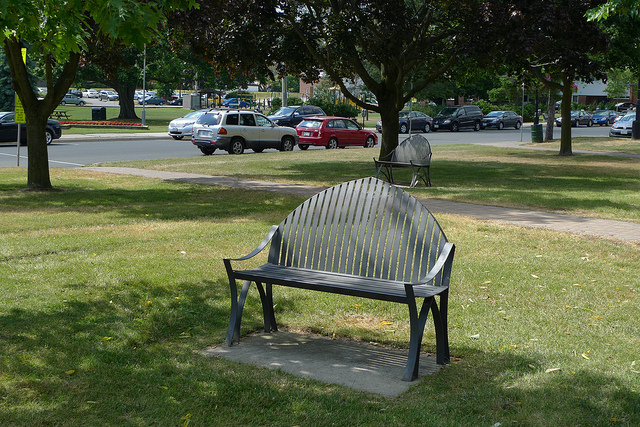

In [7]:
image_array = mmcv.imread(demo_jpg, channel_order="rgb")
Image.fromarray(image_array)

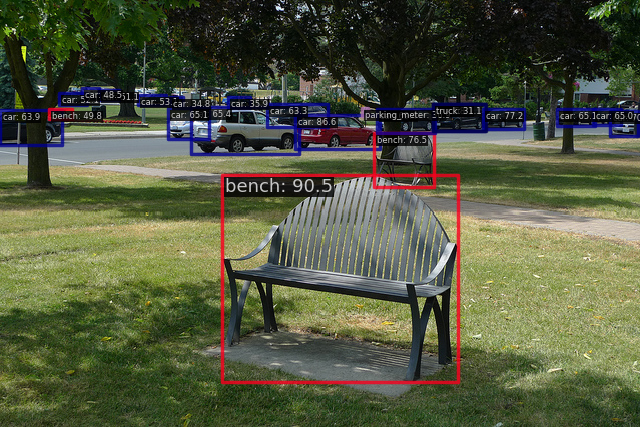

In [8]:
result = mmdet_inferencer(image_array, return_vis=True)
torch.cuda.empty_cache()
Image.fromarray(result["visualization"][0])

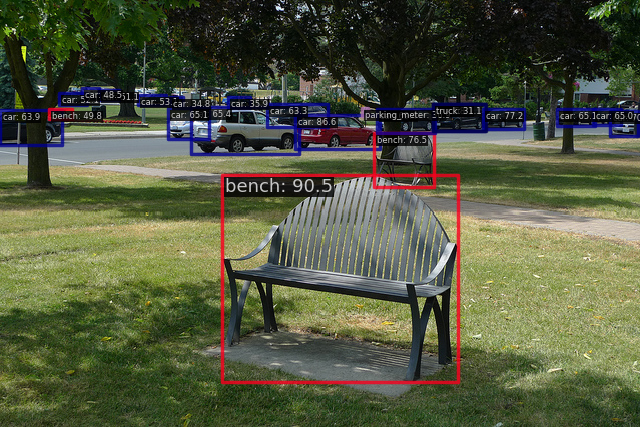

In [9]:
result = inferencer([image_array,], return_vis=True)
torch.cuda.empty_cache()
Image.fromarray(result["visualization"][0])

In [11]:
model_ts = torch.jit.load("/home/bryan/expr/co-detr/export/codetr_fp16/codetr.ts").cuda()

In [12]:
inferencer.model = model_ts

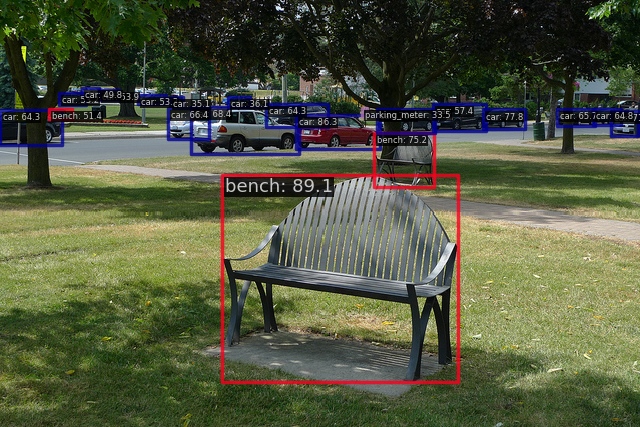

In [13]:
result_ts = inferencer([image_array,], return_vis=True, dtype=torch.float16)
torch.cuda.empty_cache()
Image.fromarray(result_ts["visualization"][0])

In [17]:
torch.jit.save?

In [18]:
torch_tensorrt._compile._parse_module_type(model_ts)

<_ModuleType.ts: 1>